In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

/Users/adexoxo/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Netural Network Algorithm

In [2]:


np.random.seed(12345) # Set initial random seed (good to always do)


''' In a neural network, activation functions are used to introduce non-linearity into the model. 
    Without activation functions, a neural network would simply be a linear regression model, 
    which would limit its ability to learn complex patterns in the data.

    Activation functions transform the output of each neuron in a way that allows the network to
    learn non-linear relationships between the input features and the target variable. 
    Different activation functions have different properties, and the choice of activation 
    function can have a significant impact on the performance of the network.'''



def activate(a, f="none"):
    if f == "none":
        y = a
    elif f == "relu":
        y = np.maximum(a,0)
    elif f == "sigmoid":
        s = 1 / (1 + np.exp(-a))
        y = s * (1 - s)
        
    
    
    return y

'''
Deactivation functions are used in backpropagation during training to compute the gradients of 
the loss function with respect to the weights of the model. During backpropagation, the error is
propagated backwards through the network, and the gradients of the loss function with respect to 
the weights are computed using the chain rule of calculus. The deactivation function of the activation function 
used in the forward pass is used to compute the derivative of the output of each neuron with respect to its input.
This derivative is then used to compute the gradient of the loss function with respect to the weights of the network.

Without deactivation functions, the gradients during backpropagation would not be well-defined, and training 
the network would not be possible. Therefore, deactivation functions are an essential component of neural network
models.

'''

def d_activate(a, f="none"):
    if f == "none":
        dy = np.ones_like(a)
    elif f == "relu":
        dy = 1 * (a > 0)
    elif f == "softmax":
        # Compute the softmax output
        softmax_output = activate(a, f="softmax")
        
        # Compute the derivative of the softmax function
        dy = softmax_output * (1 - softmax_output)
    return dy

# This is the loss for a set of predictions y_hat compared to a set of real valyes y
'''
The MSE_loss function calculates the mean squared error (MSE) between a set of predicted values y_hat 
and a set of true values y. The MSE is a commonly used loss function in regression problems, where 
the goal is to predict a continuous target variable.
'''

def MSE_loss(y_hat, y):
    return 1/2 * np.mean((y_hat-y)**2)


# This is the derivative of the loss with respect to the predicted value y_hat
'''
In the context of a neural network, during the training phase, the network is updated by computing the gradients
of the loss function with respect to the weights of the network, and then adjusting the weights in the direction of
the negative gradient using an optimization algorithm such as gradient descent.

To compute the gradients, we need to calculate the derivative of the loss function with respect to the predicted
output of the model.'''

def d_MSE_loss(y_hat, y):
    m = y.shape[0]
    return 1./m * (y_hat-y)

'''
A definition of the fordward propagation through a single layer.
Propagate a signal through a layer in a neueral network.
'''

def propagate_forward(w, a, b, f="none"):
    z = activate(np.dot(a,w) + b, f)
    return z

    
'''
A definition of a backward propagation through a single layer.
Calculate the backward gradients that are passed throught the layer in the backward pass.
'''
def propagate_backward(w, a, b, dl_dz, f="none"):
    dl = d_activate(np.dot(a,w) + b, f) * dl_dz
    dw = np.dot(a.T, dl)
    db = np.sum(dl, axis=0)
    da = np.dot(dl, w.T)
    
    return dw, db, da


In [3]:
class NeuralNet(object):
    
     
    '''The shape of the last layer of weights would be (n_m, output_dim) 
             where n_m is the number of neurons in the previous layer.'''
  
    def __init__ (self, input_dim, output_dim, neurons):
        
        self.ws = [np.random.normal(0,2,(n,m)) for n,m in
                   zip([input_dim] + neurons, neurons + [output_dim])]
        
        self.bs = [np.zeros((1,m)) for m in neurons + [output_dim]]
        
        self.activations = ["relu"] * len(neurons) + ["none"]
        
    '''
    The forward method in the program appears to propagate the input x through the neural network 
    by applying the propagate_forward function to each layer's weights w, activation function f, and
    bias b, and then returning the final output.
    '''
    
    def forward(self, x):
        for w,b,f in zip(self.ws, self.bs, self.activations):
            x = propagate_forward(w,x,b,f) 
        return x
    
    '''
     The adjust_weights method in the program appears to propagate the input with the batch side through the neural
     network by applying the propagate_forward function to each layer's weights w, activation function f, and bias n,
     and then it will calculate the loss function. finally it will propagate_backward to update the weights and bias 
     of the neural network.
    '''
   
    def adjust_weights(self, x, y, alpha):
                
        a = x
        al = []
        bl = []
        
        for w,b,f in zip(self.ws, self.bs, self.activations):
            al.append(a)
            a = propagate_forward(w,a,b,f)
            bl.append(a)
        
        loss = MSE_loss(a,y)
        da = d_MSE_loss(a,y)
        
        dwl = []
        dbl = []
        
        for w,b,f,x,z in reversed(list(zip(self.ws, self.bs, self.activations, al, bl))):
            
            dw, db, da = propagate_backward(w,x,b, da,f)
            dwl.append(dw)
            dbl.append(db)
            '''
            weights and bias updates
            '''  
            w -= alpha * dw
            b -= alpha * db
                        
        return loss
    
    
    def evaluate(self, x, y, batch_size=64):
            n_samples = x.shape[0]
            n_batches = n_samples // batch_size
            if n_samples % batch_size != 0:
                n_batches += 1

            total_loss = 0
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, n_samples)
                batch_x = x[start_idx:end_idx]
                batch_y = y[start_idx:end_idx]
                loss = MSE_loss(self.forward(batch_x), batch_y)
                total_loss += loss 

            total_loss /= n_samples
            return total_loss
   
    def train_net(self, x, y, X_val , y_val, batch_size=64, alpha=1e-4, epochs=100, validation_data=None, early_stopping_patience=10):
        n_samples = x.shape[0]
        n_batches = n_samples // batch_size
        if n_samples % batch_size != 0:
            n_batches += 1
            
        losses = []
        val_losses=[]
        
        for epoch in range(epochs):
            epoch_loss = 0
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, n_samples)
                batch_x = x[start_idx:end_idx]
                batch_y = y[start_idx:end_idx]
                loss = self.adjust_weights(batch_x, batch_y, alpha)
                epoch_loss += loss 
            epoch_loss /= n_samples
            losses.append(epoch_loss)
            
            if validation_data is not None:
                val_loss = self.evaluate(X_val , y_val,batch_size)
                val_losses.append(val_loss)
                if early_stopping_patience is not None and epoch >= early_stopping_patience:
                    best_val_loss = min(val_losses[-early_stopping_patience:])
                    if val_loss > best_val_loss:
                        print(f"Stopping early at epoch {epoch} with validation loss {val_loss:.5f}")
                        break
            print(f"Epoch {epoch+1}/{epochs}, loss {epoch_loss:.5f}")
        return losses, val_losses
    

# Wine Dataset

Epoch 1/1000, loss 828.01637
Epoch 2/1000, loss 322.28818
Epoch 3/1000, loss 26.44012
Epoch 4/1000, loss 15.84774
Epoch 5/1000, loss 11.85540
Epoch 6/1000, loss 9.73726
Epoch 7/1000, loss 8.34588
Epoch 8/1000, loss 7.32342
Epoch 9/1000, loss 6.52639
Epoch 10/1000, loss 5.88509
Epoch 11/1000, loss 5.35902
Epoch 12/1000, loss 4.92290
Epoch 13/1000, loss 4.55913
Epoch 14/1000, loss 4.24637
Epoch 15/1000, loss 3.97594
Epoch 16/1000, loss 3.73961
Epoch 17/1000, loss 3.53009
Epoch 18/1000, loss 3.34084
Epoch 19/1000, loss 3.16999
Epoch 20/1000, loss 3.01520
Epoch 21/1000, loss 2.87426
Epoch 22/1000, loss 2.74628
Epoch 23/1000, loss 2.62969
Epoch 24/1000, loss 2.52172
Epoch 25/1000, loss 2.42189
Epoch 26/1000, loss 2.32909
Epoch 27/1000, loss 2.24443
Epoch 28/1000, loss 2.16499
Epoch 29/1000, loss 2.09028
Epoch 30/1000, loss 2.01990
Epoch 31/1000, loss 1.95365
Epoch 32/1000, loss 1.89105
Epoch 33/1000, loss 1.83181
Epoch 34/1000, loss 1.77594
Epoch 35/1000, loss 1.72294
Epoch 36/1000, loss 1.

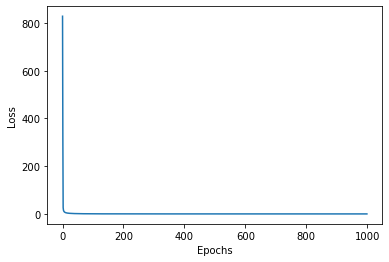

MSE on test set: 2749.83885440799
layers and their neurons: [32, 16] learning_rate: 0.0001
Epoch 1/1000, loss 2071.97694
Epoch 2/1000, loss 410.80195
Epoch 3/1000, loss 81.66687
Epoch 4/1000, loss 43.03374
Epoch 5/1000, loss 31.23182
Epoch 6/1000, loss 24.70821
Epoch 7/1000, loss 20.36829
Epoch 8/1000, loss 17.18957
Epoch 9/1000, loss 14.73900
Epoch 10/1000, loss 12.79534
Epoch 11/1000, loss 11.25880
Epoch 12/1000, loss 10.01634
Epoch 13/1000, loss 9.00838
Epoch 14/1000, loss 8.16656
Epoch 15/1000, loss 7.44861
Epoch 16/1000, loss 6.82758
Epoch 17/1000, loss 6.28019
Epoch 18/1000, loss 5.79364
Epoch 19/1000, loss 5.36820
Epoch 20/1000, loss 4.99213
Epoch 21/1000, loss 4.65862
Epoch 22/1000, loss 4.36326
Epoch 23/1000, loss 4.09686
Epoch 24/1000, loss 3.85800
Epoch 25/1000, loss 3.64284
Epoch 26/1000, loss 3.44822
Epoch 27/1000, loss 3.27097
Epoch 28/1000, loss 3.10227
Epoch 29/1000, loss 2.94902
Epoch 30/1000, loss 2.80333
Epoch 31/1000, loss 2.66840
Epoch 32/1000, loss 2.54770
Epoch 3

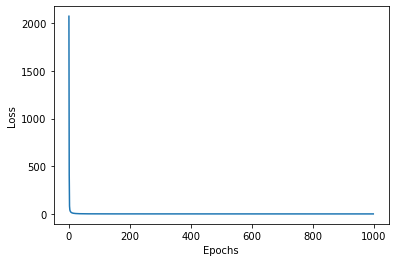

MSE on test set: 167.12074129782053
layers and their neurons: [32, 16] learning_rate: 0.0001
Epoch 1/1000, loss 403.42175
Epoch 2/1000, loss 387.62889
Epoch 3/1000, loss 373.10585
Epoch 4/1000, loss 359.72322
Epoch 5/1000, loss 347.35666
Epoch 6/1000, loss 335.91035
Epoch 7/1000, loss 325.27409
Epoch 8/1000, loss 315.35466
Epoch 9/1000, loss 306.12564
Epoch 10/1000, loss 297.53884
Epoch 11/1000, loss 289.54816
Epoch 12/1000, loss 282.11236
Epoch 13/1000, loss 275.16494
Epoch 14/1000, loss 268.65175
Epoch 15/1000, loss 262.53213
Epoch 16/1000, loss 256.78781
Epoch 17/1000, loss 251.38742
Epoch 18/1000, loss 246.29077
Epoch 19/1000, loss 241.47320
Epoch 20/1000, loss 236.91234
Epoch 21/1000, loss 232.59246
Epoch 22/1000, loss 228.49071
Epoch 23/1000, loss 224.59135
Epoch 24/1000, loss 220.86994
Epoch 25/1000, loss 217.32024
Epoch 26/1000, loss 213.93367
Epoch 27/1000, loss 210.70078
Epoch 28/1000, loss 207.60640
Epoch 29/1000, loss 204.63967
Epoch 30/1000, loss 201.78356
Epoch 31/1000, l

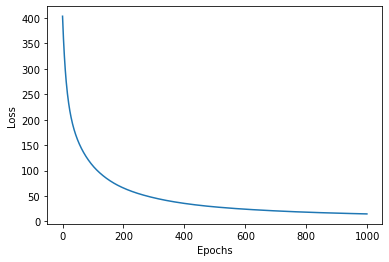

MSE on test set: 27061.160065451935
layers and their neurons: [32, 16] learning_rate: 1e-06
Epoch 1/1000, loss 10744.03336
Epoch 2/1000, loss 305789942.95406
Epoch 3/1000, loss 1155774881.37611
Epoch 4/1000, loss 3.36715
Epoch 5/1000, loss 3.33420
Epoch 6/1000, loss 3.30159
Epoch 7/1000, loss 3.26932
Epoch 8/1000, loss 3.23737
Epoch 9/1000, loss 3.20576
Epoch 10/1000, loss 3.17446
Epoch 11/1000, loss 3.14348
Epoch 12/1000, loss 3.11281
Epoch 13/1000, loss 3.08280
Epoch 14/1000, loss 3.07489
Epoch 15/1000, loss 3.07367
Epoch 16/1000, loss 3.07244
Epoch 17/1000, loss 3.07121
Epoch 18/1000, loss 3.06998
Epoch 19/1000, loss 3.06875
Epoch 20/1000, loss 3.06753
Epoch 21/1000, loss 3.06630
Epoch 22/1000, loss 3.06508
Epoch 23/1000, loss 3.06385
Epoch 24/1000, loss 3.06263
Epoch 25/1000, loss 3.06140
Epoch 26/1000, loss 3.06018
Epoch 27/1000, loss 3.05896
Epoch 28/1000, loss 3.05773
Epoch 29/1000, loss 3.05651
Epoch 30/1000, loss 3.05529
Epoch 31/1000, loss 3.05407
Epoch 32/1000, loss 3.05285


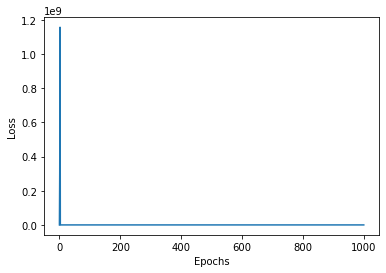

MSE on test set: 312.50391248170246
layers and their neurons: [16, 8, 4] learning_rate: 0.0001
Epoch 1/1000, loss 1209.91347
Epoch 2/1000, loss 170.32501
Epoch 3/1000, loss 0.92990
Epoch 4/1000, loss 0.86225
Epoch 5/1000, loss 0.80558
Epoch 6/1000, loss 0.75765
Epoch 7/1000, loss 0.71537
Epoch 8/1000, loss 0.67746
Epoch 9/1000, loss 0.64261
Epoch 10/1000, loss 0.61000
Epoch 11/1000, loss 0.57840
Epoch 12/1000, loss 0.54995
Epoch 13/1000, loss 0.52412
Epoch 14/1000, loss 0.50055
Epoch 15/1000, loss 0.47903
Epoch 16/1000, loss 0.45929
Epoch 17/1000, loss 0.44113
Epoch 18/1000, loss 0.42435
Epoch 19/1000, loss 0.40881
Epoch 20/1000, loss 0.39436
Epoch 21/1000, loss 0.38096
Epoch 22/1000, loss 0.36843
Epoch 23/1000, loss 0.35664
Epoch 24/1000, loss 0.34553
Epoch 25/1000, loss 0.33504
Epoch 26/1000, loss 0.32501
Epoch 27/1000, loss 0.31554
Epoch 28/1000, loss 0.30656
Epoch 29/1000, loss 0.29806
Epoch 30/1000, loss 0.28999
Epoch 31/1000, loss 0.28231
Epoch 32/1000, loss 0.27501
Epoch 33/1000

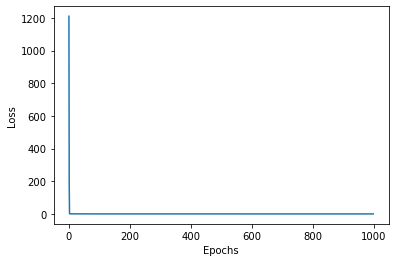

MSE on test set: 5.83531426786149
layers and their neurons: [16, 8, 4] learning_rate: 0.0001
Epoch 1/1000, loss 47.99871
Epoch 2/1000, loss 46.73822
Epoch 3/1000, loss 45.54474
Epoch 4/1000, loss 44.41236
Epoch 5/1000, loss 43.33580
Epoch 6/1000, loss 42.31039
Epoch 7/1000, loss 41.33194
Epoch 8/1000, loss 40.39673
Epoch 9/1000, loss 39.50139
Epoch 10/1000, loss 38.64292
Epoch 11/1000, loss 37.81863
Epoch 12/1000, loss 37.02608
Epoch 13/1000, loss 36.26307
Epoch 14/1000, loss 35.52761
Epoch 15/1000, loss 34.81792
Epoch 16/1000, loss 34.13235
Epoch 17/1000, loss 33.46942
Epoch 18/1000, loss 32.82779
Epoch 19/1000, loss 32.20623
Epoch 20/1000, loss 31.60360
Epoch 21/1000, loss 31.01888
Epoch 22/1000, loss 30.45112
Epoch 23/1000, loss 29.89946
Epoch 24/1000, loss 29.36309
Epoch 25/1000, loss 28.84127
Epoch 26/1000, loss 28.33333
Epoch 27/1000, loss 27.83863
Epoch 28/1000, loss 27.35659
Epoch 29/1000, loss 26.88666
Epoch 30/1000, loss 26.42833
Epoch 31/1000, loss 25.98113
Epoch 32/1000, lo

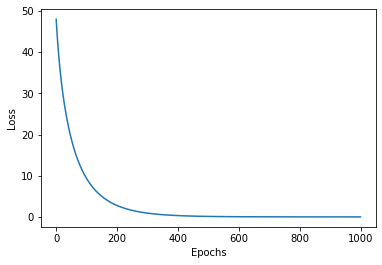

MSE on test set: 9.574990712311918
layers and their neurons: [16, 8, 4] learning_rate: 1e-06
Epoch 1/1000, loss 14.87497
Epoch 2/1000, loss 3.28464
Epoch 3/1000, loss 1.72522
Epoch 4/1000, loss 1.04499
Epoch 5/1000, loss 0.68168
Epoch 6/1000, loss 0.46349
Epoch 7/1000, loss 0.32354
Epoch 8/1000, loss 0.23064
Epoch 9/1000, loss 0.16768
Epoch 10/1000, loss 0.12440
Epoch 11/1000, loss 0.09433
Epoch 12/1000, loss 0.07330
Epoch 13/1000, loss 0.05850
Epoch 14/1000, loss 0.04805
Epoch 15/1000, loss 0.04063
Epoch 16/1000, loss 0.03526
Epoch 17/1000, loss 0.03140
Epoch 18/1000, loss 0.02863
Epoch 19/1000, loss 0.02664
Epoch 20/1000, loss 0.02521
Epoch 21/1000, loss 0.02417
Epoch 22/1000, loss 0.02342
Epoch 23/1000, loss 0.02288
Epoch 24/1000, loss 0.02249
Epoch 25/1000, loss 0.02220
Epoch 26/1000, loss 0.02199
Epoch 27/1000, loss 0.02183
Epoch 28/1000, loss 0.02171
Epoch 29/1000, loss 0.02162
Epoch 30/1000, loss 0.02156
Epoch 31/1000, loss 0.02150
Epoch 32/1000, loss 0.02146
Epoch 33/1000, loss

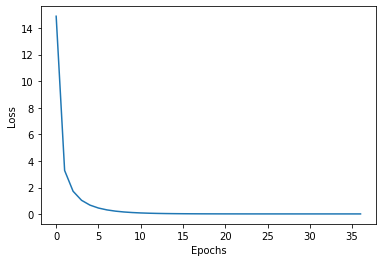

MSE on test set: 719.6312053668828
layers and their neurons: [4, 16, 4] learning_rate: 0.0001
Epoch 1/1000, loss 17629.63635
Epoch 2/1000, loss 0.01729
Epoch 3/1000, loss 0.01728
Epoch 4/1000, loss 0.01728
Epoch 5/1000, loss 0.01727
Epoch 6/1000, loss 0.01726
Epoch 7/1000, loss 0.01726
Epoch 8/1000, loss 0.01725
Epoch 9/1000, loss 0.01725
Epoch 10/1000, loss 0.01724
Epoch 11/1000, loss 0.01723
Epoch 12/1000, loss 0.01723
Epoch 13/1000, loss 0.01722
Epoch 14/1000, loss 0.01722
Epoch 15/1000, loss 0.01721
Epoch 16/1000, loss 0.01720
Epoch 17/1000, loss 0.01720
Epoch 18/1000, loss 0.01719
Epoch 19/1000, loss 0.01718
Epoch 20/1000, loss 0.01718
Epoch 21/1000, loss 0.01717
Epoch 22/1000, loss 0.01717
Epoch 23/1000, loss 0.01716
Epoch 24/1000, loss 0.01715
Epoch 25/1000, loss 0.01715
Epoch 26/1000, loss 0.01714
Epoch 27/1000, loss 0.01714
Epoch 28/1000, loss 0.01713
Epoch 29/1000, loss 0.01712
Epoch 30/1000, loss 0.01712
Epoch 31/1000, loss 0.01711
Epoch 32/1000, loss 0.01711
Epoch 33/1000, 

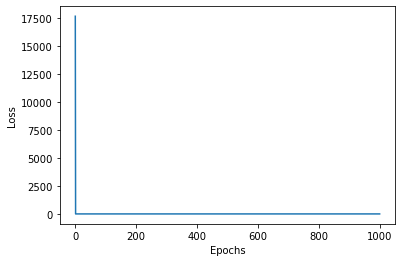

MSE on test set: 6.779060086215578
layers and their neurons: [4, 16, 4] learning_rate: 0.0001
Epoch 1/1000, loss 194.16531
Epoch 2/1000, loss 175.07217
Epoch 3/1000, loss 158.72109
Epoch 4/1000, loss 144.58561
Epoch 5/1000, loss 132.27635
Epoch 6/1000, loss 121.48668
Epoch 7/1000, loss 112.02745
Epoch 8/1000, loss 103.69700
Epoch 9/1000, loss 96.33669
Epoch 10/1000, loss 89.80699
Epoch 11/1000, loss 83.96820
Epoch 12/1000, loss 78.75548
Epoch 13/1000, loss 74.09213
Epoch 14/1000, loss 69.90731
Epoch 15/1000, loss 66.14866
Epoch 16/1000, loss 62.74265
Epoch 17/1000, loss 59.64122
Epoch 18/1000, loss 56.82336
Epoch 19/1000, loss 54.23777
Epoch 20/1000, loss 51.80055
Epoch 21/1000, loss 49.56673
Epoch 22/1000, loss 47.51619
Epoch 23/1000, loss 45.63151
Epoch 24/1000, loss 43.89737
Epoch 25/1000, loss 42.29910
Epoch 26/1000, loss 40.80382
Epoch 27/1000, loss 39.42130
Epoch 28/1000, loss 38.14426
Epoch 29/1000, loss 36.95310
Epoch 30/1000, loss 35.83713
Epoch 31/1000, loss 34.79955
Epoch 32

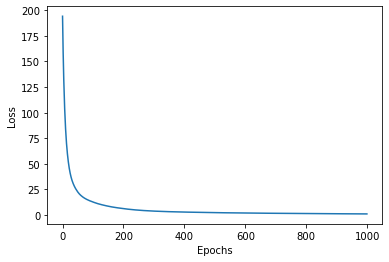

MSE on test set: 4442.9100704256725
layers and their neurons: [4, 16, 4] learning_rate: 1e-06


In [4]:


# Load and preprocess the wine Dataset
df1 = pd.read_csv('wine.tmls')

# Standardize the data
X =  StandardScaler().fit_transform(df1.iloc[1:, :-1])
y= df1.iloc[1:, -1]
y = np.asarray(y)
y = y.reshape(-1, 1)
y = y.astype('float64')
# Split the dataset into training and testing sets
split_idx = int(0.8 * X.shape[0])
Xtrain, ytrain = X[:split_idx], y[:split_idx]
X_test, y_test  = X[split_idx:], y[split_idx:]

# split the dataset into training and validation set
val_split = int(0.9 * Xtrain.shape[0])
X_train, y_train =Xtrain[:val_split], ytrain[:val_split]
X_val , y_val = Xtrain[val_split:], ytrain[val_split:]

# Two Hyperparameters( the learning rate and number of hidden layers). we can fine tune this Hyperparameters.
alphas = [1e-4, 1e-4, 1e-6]
neurons = [[32, 16], [16, 8, 4], [4, 16, 4]]


        
for n in neurons:
    losses = []
    for alpha in alphas:
        
        # Define the neural network
        nn = NeuralNet(X.shape[1], 1, n)
        
        # Train the neural network
        epoch =[]
        loss, _ = nn.train_net(X_train, y_train, X_val, y_val, batch_size=64, alpha=alpha, epochs=1000, validation_data=1, early_stopping_patience=5)
        
        losses.append(loss)
        epoch.append(epoch)
        plt.plot(loss)
        plt.xlabel("Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()

        # Evaluate the performance of the neural network on the test set
        y_pred = nn.forward(X_test)
        mse = ((y_pred - y_test)**2).mean()

        print("MSE on test set:", mse)
        print('layers and their neurons:', n, 'learning_rate:', alpha)
       


# Breast Cancer Dataset

X_train (503, 9) y_train (503, 1) X_val (56, 9) y_val (56, 1) X_test (140, 9) y_test (140, 1)
Epoch 1/1000, loss 142.18959
Epoch 2/1000, loss 22.59549
Epoch 3/1000, loss 14.65517
Epoch 4/1000, loss 10.87263
Epoch 5/1000, loss 8.69120
Epoch 6/1000, loss 7.26086
Epoch 7/1000, loss 6.23944
Epoch 8/1000, loss 5.47721
Epoch 9/1000, loss 4.88206
Epoch 10/1000, loss 4.40218
Epoch 11/1000, loss 4.00394
Epoch 12/1000, loss 3.67143
Epoch 13/1000, loss 3.38751
Epoch 14/1000, loss 3.14048
Epoch 15/1000, loss 2.91924
Epoch 16/1000, loss 2.72737
Epoch 17/1000, loss 2.55896
Epoch 18/1000, loss 2.40999
Epoch 19/1000, loss 2.27670
Epoch 20/1000, loss 2.15627
Epoch 21/1000, loss 2.04610
Epoch 22/1000, loss 1.94629
Epoch 23/1000, loss 1.85543
Epoch 24/1000, loss 1.77220
Epoch 25/1000, loss 1.69581
Epoch 26/1000, loss 1.62604
Epoch 27/1000, loss 1.56146
Epoch 28/1000, loss 1.50141
Epoch 29/1000, loss 1.44539
Epoch 30/1000, loss 1.39312
Epoch 31/1000, loss 1.34376
Epoch 32/1000, loss 1.29711
Epoch 33/1000,

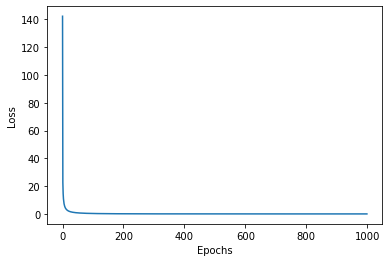

MSE on test set: 1.8125893354696205
layers and their neurons: [32, 16] learning_rate: 0.0001
Epoch 1/1000, loss 174.97921
Epoch 2/1000, loss 89.03581
Epoch 3/1000, loss 59.46057
Epoch 4/1000, loss 45.71020
Epoch 5/1000, loss 37.60946
Epoch 6/1000, loss 32.02270
Epoch 7/1000, loss 27.88963
Epoch 8/1000, loss 24.72215
Epoch 9/1000, loss 22.23153
Epoch 10/1000, loss 20.18648
Epoch 11/1000, loss 18.46051
Epoch 12/1000, loss 17.00046
Epoch 13/1000, loss 15.74928
Epoch 14/1000, loss 14.68221
Epoch 15/1000, loss 13.73608
Epoch 16/1000, loss 12.88943
Epoch 17/1000, loss 12.12367
Epoch 18/1000, loss 11.43468
Epoch 19/1000, loss 10.82267
Epoch 20/1000, loss 10.28054
Epoch 21/1000, loss 9.80032
Epoch 22/1000, loss 9.36618
Epoch 23/1000, loss 8.97149
Epoch 24/1000, loss 8.60605
Epoch 25/1000, loss 8.27013
Epoch 26/1000, loss 7.95930
Epoch 27/1000, loss 7.67321
Epoch 28/1000, loss 7.41020
Epoch 29/1000, loss 7.17218
Epoch 30/1000, loss 6.94894
Epoch 31/1000, loss 6.73979
Epoch 32/1000, loss 6.54298

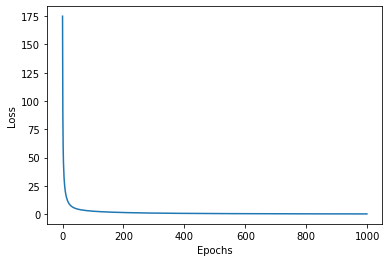

MSE on test set: 53.44679846157881
layers and their neurons: [32, 16] learning_rate: 1e-05
Epoch 1/1000, loss 205.82288
Epoch 2/1000, loss 178.64290
Epoch 3/1000, loss 156.18827
Epoch 4/1000, loss 137.64151
Epoch 5/1000, loss 121.98031
Epoch 6/1000, loss 108.61036
Epoch 7/1000, loss 97.18987
Epoch 8/1000, loss 87.44781
Epoch 9/1000, loss 79.05366
Epoch 10/1000, loss 71.81087
Epoch 11/1000, loss 65.54255
Epoch 12/1000, loss 60.08604
Epoch 13/1000, loss 55.33775
Epoch 14/1000, loss 51.18367
Epoch 15/1000, loss 47.53850
Epoch 16/1000, loss 44.33669
Epoch 17/1000, loss 41.52299
Epoch 18/1000, loss 39.04456
Epoch 19/1000, loss 36.85993
Epoch 20/1000, loss 34.93057
Epoch 21/1000, loss 33.21564
Epoch 22/1000, loss 31.68806
Epoch 23/1000, loss 30.32461
Epoch 24/1000, loss 29.10709
Epoch 25/1000, loss 28.01833
Epoch 26/1000, loss 27.04060
Epoch 27/1000, loss 26.16051
Epoch 28/1000, loss 25.36538
Epoch 29/1000, loss 24.64505
Epoch 30/1000, loss 23.99131
Epoch 31/1000, loss 23.39625
Epoch 32/1000

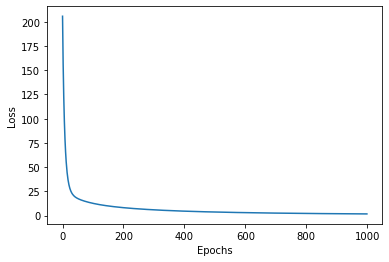

MSE on test set: 365.5482293287184
layers and their neurons: [32, 16] learning_rate: 1e-06
Epoch 1/1000, loss 107.71191
Epoch 2/1000, loss 0.72355
Epoch 3/1000, loss 0.49924
Epoch 4/1000, loss 0.39188
Epoch 5/1000, loss 0.32937
Epoch 6/1000, loss 0.28868
Epoch 7/1000, loss 0.26120
Epoch 8/1000, loss 0.24045
Epoch 9/1000, loss 0.22342
Epoch 10/1000, loss 0.20914
Epoch 11/1000, loss 0.19721
Epoch 12/1000, loss 0.18697
Epoch 13/1000, loss 0.17809
Epoch 14/1000, loss 0.17046
Epoch 15/1000, loss 0.16380
Epoch 16/1000, loss 0.15789
Epoch 17/1000, loss 0.15265
Epoch 18/1000, loss 0.14794
Epoch 19/1000, loss 0.14370
Epoch 20/1000, loss 0.13987
Epoch 21/1000, loss 0.13641
Epoch 22/1000, loss 0.13327
Epoch 23/1000, loss 0.13039
Epoch 24/1000, loss 0.12775
Epoch 25/1000, loss 0.12532
Epoch 26/1000, loss 0.12307
Epoch 27/1000, loss 0.12099
Epoch 28/1000, loss 0.11911
Epoch 29/1000, loss 0.11736
Epoch 30/1000, loss 0.11575
Epoch 31/1000, loss 0.11430
Epoch 32/1000, loss 0.11294
Epoch 33/1000, loss 

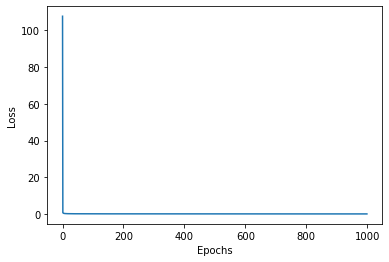

MSE on test set: 1.717234587624546
layers and their neurons: [16, 8, 4] learning_rate: 0.0001
Epoch 1/1000, loss 19.56508
Epoch 2/1000, loss 9.79869
Epoch 3/1000, loss 6.45854
Epoch 4/1000, loss 4.66422
Epoch 5/1000, loss 3.57420
Epoch 6/1000, loss 2.84964
Epoch 7/1000, loss 2.33816
Epoch 8/1000, loss 1.96003
Epoch 9/1000, loss 1.66814
Epoch 10/1000, loss 1.44039
Epoch 11/1000, loss 1.25941
Epoch 12/1000, loss 1.11321
Epoch 13/1000, loss 0.99322
Epoch 14/1000, loss 0.87178
Epoch 15/1000, loss 0.77476
Epoch 16/1000, loss 0.69679
Epoch 17/1000, loss 0.63325
Epoch 18/1000, loss 0.58138
Epoch 19/1000, loss 0.53869
Epoch 20/1000, loss 0.50325
Epoch 21/1000, loss 0.47355
Epoch 22/1000, loss 0.44825
Epoch 23/1000, loss 0.42648
Epoch 24/1000, loss 0.40768
Epoch 25/1000, loss 0.39131
Epoch 26/1000, loss 0.37693
Epoch 27/1000, loss 0.36437
Epoch 28/1000, loss 0.35388
Epoch 29/1000, loss 0.34426
Epoch 30/1000, loss 0.33542
Epoch 31/1000, loss 0.32720
Epoch 32/1000, loss 0.31959
Epoch 33/1000, los

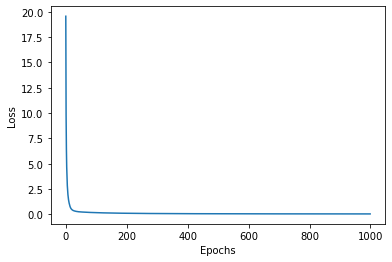

MSE on test set: 4.236788464044961
layers and their neurons: [16, 8, 4] learning_rate: 1e-05
Epoch 1/1000, loss 31.81915
Epoch 2/1000, loss 29.29863
Epoch 3/1000, loss 27.11696
Epoch 4/1000, loss 25.22683
Epoch 5/1000, loss 23.55444
Epoch 6/1000, loss 22.06839
Epoch 7/1000, loss 20.74399
Epoch 8/1000, loss 19.55427
Epoch 9/1000, loss 18.47975
Epoch 10/1000, loss 17.51067
Epoch 11/1000, loss 16.63842
Epoch 12/1000, loss 15.83602
Epoch 13/1000, loss 15.09821
Epoch 14/1000, loss 14.42257
Epoch 15/1000, loss 13.80184
Epoch 16/1000, loss 13.22611
Epoch 17/1000, loss 12.68830
Epoch 18/1000, loss 12.18497
Epoch 19/1000, loss 11.71346
Epoch 20/1000, loss 11.27111
Epoch 21/1000, loss 10.86007
Epoch 22/1000, loss 10.47759
Epoch 23/1000, loss 10.11659
Epoch 24/1000, loss 9.77592
Epoch 25/1000, loss 9.45441
Epoch 26/1000, loss 9.15008
Epoch 27/1000, loss 8.86304
Epoch 28/1000, loss 8.59302
Epoch 29/1000, loss 8.33717
Epoch 30/1000, loss 8.09401
Epoch 31/1000, loss 7.86337
Epoch 32/1000, loss 7.644

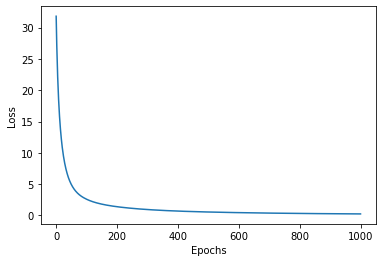

MSE on test set: 43.25898775482227
layers and their neurons: [16, 8, 4] learning_rate: 1e-06
Epoch 1/1000, loss 43.23357
Epoch 2/1000, loss 2.94966
Epoch 3/1000, loss 1.38541
Epoch 4/1000, loss 0.79505
Epoch 5/1000, loss 0.50403
Epoch 6/1000, loss 0.34647
Epoch 7/1000, loss 0.25434
Epoch 8/1000, loss 0.19806
Epoch 9/1000, loss 0.16276
Epoch 10/1000, loss 0.13963
Epoch 11/1000, loss 0.12325
Epoch 12/1000, loss 0.11048
Epoch 13/1000, loss 0.10054
Epoch 14/1000, loss 0.09284
Epoch 15/1000, loss 0.08723
Epoch 16/1000, loss 0.08298
Epoch 17/1000, loss 0.07957
Epoch 18/1000, loss 0.07661
Epoch 19/1000, loss 0.07396
Epoch 20/1000, loss 0.07155
Epoch 21/1000, loss 0.06936
Epoch 22/1000, loss 0.06741
Epoch 23/1000, loss 0.06565
Epoch 24/1000, loss 0.06407
Epoch 25/1000, loss 0.06261
Epoch 26/1000, loss 0.06125
Epoch 27/1000, loss 0.05998
Epoch 28/1000, loss 0.05878
Epoch 29/1000, loss 0.05768
Epoch 30/1000, loss 0.05667
Epoch 31/1000, loss 0.05572
Epoch 32/1000, loss 0.05484
Epoch 33/1000, loss

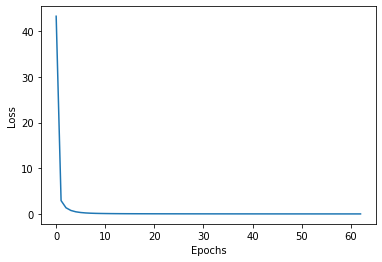

MSE on test set: 5.334405954275016
layers and their neurons: [4, 16, 4] learning_rate: 0.0001
Epoch 1/1000, loss 5.12721
Epoch 2/1000, loss 1.13099
Epoch 3/1000, loss 0.85874
Epoch 4/1000, loss 0.77385
Epoch 5/1000, loss 0.70658
Epoch 6/1000, loss 0.64750
Epoch 7/1000, loss 0.59508
Epoch 8/1000, loss 0.54835
Epoch 9/1000, loss 0.50652
Epoch 10/1000, loss 0.46892
Epoch 11/1000, loss 0.43501
Epoch 12/1000, loss 0.40432
Epoch 13/1000, loss 0.37647
Epoch 14/1000, loss 0.35112
Epoch 15/1000, loss 0.32798
Epoch 16/1000, loss 0.30680
Epoch 17/1000, loss 0.28739
Epoch 18/1000, loss 0.26955
Epoch 19/1000, loss 0.25312
Epoch 20/1000, loss 0.23796
Epoch 21/1000, loss 0.22396
Epoch 22/1000, loss 0.21100
Epoch 23/1000, loss 0.19899
Epoch 24/1000, loss 0.18784
Epoch 25/1000, loss 0.17748
Epoch 26/1000, loss 0.16784
Epoch 27/1000, loss 0.15886
Epoch 28/1000, loss 0.15049
Epoch 29/1000, loss 0.14267
Epoch 30/1000, loss 0.13537
Epoch 31/1000, loss 0.12854
Epoch 32/1000, loss 0.12214
Epoch 33/1000, loss

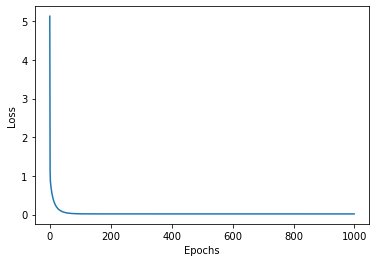

MSE on test set: 1.0718763803562712
layers and their neurons: [4, 16, 4] learning_rate: 1e-05
Epoch 1/1000, loss 531.25937
Epoch 2/1000, loss 353.06865
Epoch 3/1000, loss 256.07774
Epoch 4/1000, loss 196.04662
Epoch 5/1000, loss 155.60527
Epoch 6/1000, loss 126.78014
Epoch 7/1000, loss 105.58188
Epoch 8/1000, loss 89.26217
Epoch 9/1000, loss 76.51031
Epoch 10/1000, loss 66.30455
Epoch 11/1000, loss 57.99836
Epoch 12/1000, loss 51.10240
Epoch 13/1000, loss 45.36462
Epoch 14/1000, loss 40.58092
Epoch 15/1000, loss 36.48964
Epoch 16/1000, loss 32.94909
Epoch 17/1000, loss 29.92174
Epoch 18/1000, loss 27.31582
Epoch 19/1000, loss 25.07429
Epoch 20/1000, loss 23.11486
Epoch 21/1000, loss 21.43264
Epoch 22/1000, loss 19.98048
Epoch 23/1000, loss 18.71760
Epoch 24/1000, loss 17.61488
Epoch 25/1000, loss 16.64419
Epoch 26/1000, loss 15.76163
Epoch 27/1000, loss 14.97356
Epoch 28/1000, loss 14.27145
Epoch 29/1000, loss 13.64868
Epoch 30/1000, loss 13.09347
Epoch 31/1000, loss 12.59709
Epoch 32/

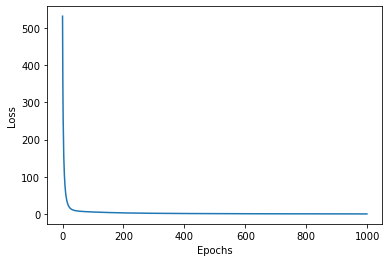

MSE on test set: 91.15968098154701
layers and their neurons: [4, 16, 4] learning_rate: 1e-06


In [5]:
# Load and preprocess the Breast Cancer Dataset
df = pd.read_csv('breast_cancer.data').iloc[:, 1:]

# Replace '?' with NaN and convert all values to float
df = df.replace('?', np.nan).astype(float)

# Replace missing values with the mean of the corresponding column
df.fillna(df.mean(), inplace=True)

# Standardize the data
X = StandardScaler().fit_transform(df.iloc[:, :-1])

y= df.iloc[:, -1]
y = np.asarray(y)
y = y.reshape(-1, 1)

# Split the dataset into training and testing sets
split_idx = int(0.8 * X.shape[0])
Xtrain, ytrain = X[:split_idx], y[:split_idx]
X_test, y_test  = X[split_idx:], y[split_idx:]
# split the dataset into training and validation set
val_split = int(0.9 * Xtrain.shape[0])
X_train, y_train =Xtrain[:val_split], ytrain[:val_split]
X_val , y_val = Xtrain[val_split:], ytrain[val_split:]
print('X_train', X_train.shape, 'y_train', y_train.shape, 'X_val', X_val.shape, 'y_val', y_val.shape,'X_test', X_test.shape, 'y_test', y_test.shape)


# Two Hyperparameters( the learning rate and number of hidden layers). we can fine tune this Hyperparameters.
alphas = [1e-4, 1e-5, 1e-6]
neurons = [[32, 16], [16, 8, 4], [4, 16, 4]]

for n in neurons:
    losses = []
    for alpha in alphas:
        
        # Define the neural network
        nn = NeuralNet(X.shape[1], 1, n)
        # Train the neural network
        epoch =[]
        loss, _ = nn.train_net(X_train, y_train, X_val, y_val, batch_size=64, alpha=alpha, epochs=1000, validation_data=1, early_stopping_patience=5)
        
        losses.append(loss)
        epoch.append(epoch)
        plt.plot(loss)
        plt.xlabel("Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()

        # Evaluate the performance of the neural network on the test set
        y_pred = nn.forward(X_test)
        mse = ((y_pred - y_test)**2).mean()

        print("MSE on test set:", mse)
        print('layers and their neurons:', n, 'learning_rate:', alpha)

# Iris Dataset

X_train (108, 4) y_train (108, 1) X_val (12, 4) y_val (12, 1) X_test (30, 4) y_test (30, 1)
Epoch 1/1000, loss 63.01917
Epoch 2/1000, loss 92.39332
Epoch 3/1000, loss 545.82308
Epoch 4/1000, loss 1092.49644
Epoch 5/1000, loss 41.74415
Stopping early at epoch 5 with validation loss 421.53044


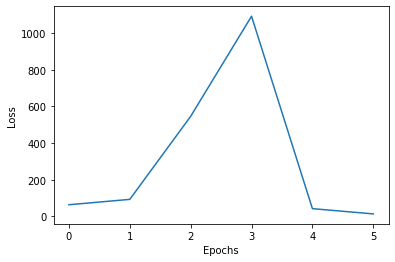

MSE on test set: 4151.836835242188
layers and their neurons: [32, 16] learning_rate: 0.0001
Epoch 1/1000, loss 9.90027
Epoch 2/1000, loss 8.55715
Epoch 3/1000, loss 7.52624
Epoch 4/1000, loss 6.73051
Epoch 5/1000, loss 6.11385
Epoch 6/1000, loss 5.63724
Epoch 7/1000, loss 5.25900
Epoch 8/1000, loss 4.95387
Epoch 9/1000, loss 4.70342
Epoch 10/1000, loss 4.49532
Epoch 11/1000, loss 4.31949
Epoch 12/1000, loss 4.16810
Epoch 13/1000, loss 4.03577
Epoch 14/1000, loss 3.91858
Epoch 15/1000, loss 3.81327
Epoch 16/1000, loss 3.71732
Epoch 17/1000, loss 3.62762
Epoch 18/1000, loss 3.54480
Epoch 19/1000, loss 3.46801
Epoch 20/1000, loss 3.39596
Epoch 21/1000, loss 3.32800
Epoch 22/1000, loss 3.26338
Epoch 23/1000, loss 3.20180
Epoch 24/1000, loss 3.14311
Epoch 25/1000, loss 3.08661
Epoch 26/1000, loss 3.03022
Epoch 27/1000, loss 2.97607
Epoch 28/1000, loss 2.92406
Epoch 29/1000, loss 2.87406
Epoch 30/1000, loss 2.82595
Epoch 31/1000, loss 2.77954
Epoch 32/1000, loss 2.73473
Epoch 33/1000, loss 2

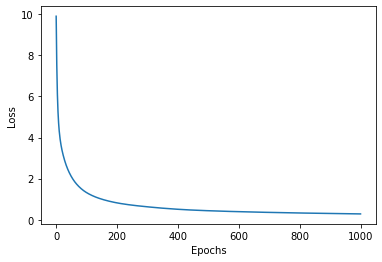

MSE on test set: 634.7946360670095
layers and their neurons: [32, 16] learning_rate: 1e-05
Epoch 1/1000, loss 137.26671
Epoch 2/1000, loss 135.13467
Epoch 3/1000, loss 133.03824
Epoch 4/1000, loss 130.93996
Epoch 5/1000, loss 128.89086
Epoch 6/1000, loss 126.88942
Epoch 7/1000, loss 124.92749
Epoch 8/1000, loss 122.99372
Epoch 9/1000, loss 121.10608
Epoch 10/1000, loss 119.26448
Epoch 11/1000, loss 117.46487
Epoch 12/1000, loss 115.70611
Epoch 13/1000, loss 113.98750
Epoch 14/1000, loss 112.30817
Epoch 15/1000, loss 110.66333
Epoch 16/1000, loss 109.05474
Epoch 17/1000, loss 107.48039
Epoch 18/1000, loss 105.92504
Epoch 19/1000, loss 104.40389
Epoch 20/1000, loss 102.91613
Epoch 21/1000, loss 101.46073
Epoch 22/1000, loss 100.03665
Epoch 23/1000, loss 98.64302
Epoch 24/1000, loss 97.27891
Epoch 25/1000, loss 95.94333
Epoch 26/1000, loss 94.63681
Epoch 27/1000, loss 93.35854
Epoch 28/1000, loss 92.10721
Epoch 29/1000, loss 90.88299
Epoch 30/1000, loss 89.68396
Epoch 31/1000, loss 88.512

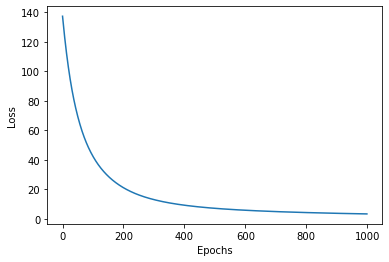

MSE on test set: 293.4015863950826
layers and their neurons: [32, 16] learning_rate: 1e-06
Epoch 1/1000, loss 887.65143
Epoch 2/1000, loss 4.73878
Epoch 3/1000, loss 2.68130
Epoch 4/1000, loss 2.21792
Epoch 5/1000, loss 1.95875
Epoch 6/1000, loss 1.76546
Epoch 7/1000, loss 1.60140
Epoch 8/1000, loss 1.45965
Epoch 9/1000, loss 1.33653
Epoch 10/1000, loss 1.22912
Epoch 11/1000, loss 1.13507
Epoch 12/1000, loss 1.04817
Epoch 13/1000, loss 0.97141
Epoch 14/1000, loss 0.90301
Epoch 15/1000, loss 0.84112
Epoch 16/1000, loss 0.78422
Epoch 17/1000, loss 0.73304
Epoch 18/1000, loss 0.68687
Epoch 19/1000, loss 0.64497
Epoch 20/1000, loss 0.60674
Epoch 21/1000, loss 0.57175
Epoch 22/1000, loss 0.53963
Epoch 23/1000, loss 0.50998
Epoch 24/1000, loss 0.48260
Epoch 25/1000, loss 0.45728
Epoch 26/1000, loss 0.43321
Epoch 27/1000, loss 0.41097
Epoch 28/1000, loss 0.39039
Epoch 29/1000, loss 0.37126
Epoch 30/1000, loss 0.35342
Epoch 31/1000, loss 0.33669
Epoch 32/1000, loss 0.32081
Epoch 33/1000, loss 

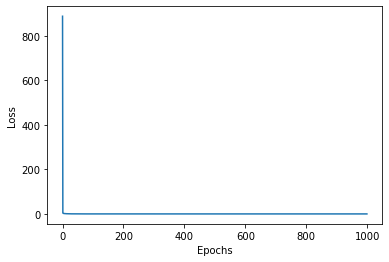

MSE on test set: 0.554429048974459
layers and their neurons: [16, 8, 4] learning_rate: 0.0001
Epoch 1/1000, loss 165.56513
Epoch 2/1000, loss 64.13237
Epoch 3/1000, loss 38.18647
Epoch 4/1000, loss 27.77422
Epoch 5/1000, loss 22.56487
Epoch 6/1000, loss 19.44978
Epoch 7/1000, loss 17.35047
Epoch 8/1000, loss 15.83026
Epoch 9/1000, loss 14.67619
Epoch 10/1000, loss 13.76096
Epoch 11/1000, loss 12.99355
Epoch 12/1000, loss 12.33707
Epoch 13/1000, loss 11.77348
Epoch 14/1000, loss 11.27561
Epoch 15/1000, loss 10.83399
Epoch 16/1000, loss 10.44349
Epoch 17/1000, loss 10.09487
Epoch 18/1000, loss 9.77257
Epoch 19/1000, loss 9.48641
Epoch 20/1000, loss 9.22697
Epoch 21/1000, loss 8.97898
Epoch 22/1000, loss 8.74794
Epoch 23/1000, loss 8.53320
Epoch 24/1000, loss 8.31457
Epoch 25/1000, loss 8.11322
Epoch 26/1000, loss 7.92887
Epoch 27/1000, loss 7.75802
Epoch 28/1000, loss 7.59548
Epoch 29/1000, loss 7.44016
Epoch 30/1000, loss 7.29063
Epoch 31/1000, loss 7.14962
Epoch 32/1000, loss 7.01700
E

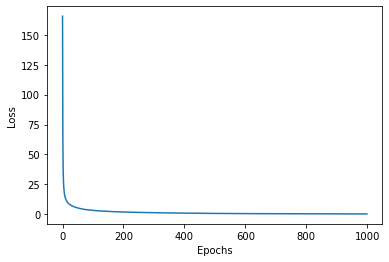

MSE on test set: 93.53033501153706
layers and their neurons: [16, 8, 4] learning_rate: 1e-05
Epoch 1/1000, loss 280.96336
Epoch 2/1000, loss 259.93751
Epoch 3/1000, loss 242.06204
Epoch 4/1000, loss 226.54651
Epoch 5/1000, loss 212.89204
Epoch 6/1000, loss 200.94491
Epoch 7/1000, loss 189.88289
Epoch 8/1000, loss 180.07379
Epoch 9/1000, loss 171.35211
Epoch 10/1000, loss 163.50790
Epoch 11/1000, loss 156.24417
Epoch 12/1000, loss 149.51537
Epoch 13/1000, loss 143.18777
Epoch 14/1000, loss 137.30348
Epoch 15/1000, loss 131.80413
Epoch 16/1000, loss 126.64670
Epoch 17/1000, loss 121.80837
Epoch 18/1000, loss 117.25803
Epoch 19/1000, loss 112.96192
Epoch 20/1000, loss 108.93493
Epoch 21/1000, loss 105.14235
Epoch 22/1000, loss 101.64723
Epoch 23/1000, loss 98.35908
Epoch 24/1000, loss 95.23980
Epoch 25/1000, loss 92.28242
Epoch 26/1000, loss 89.48200
Epoch 27/1000, loss 86.81921
Epoch 28/1000, loss 84.28123
Epoch 29/1000, loss 81.86186
Epoch 30/1000, loss 79.55716
Epoch 31/1000, loss 77.3

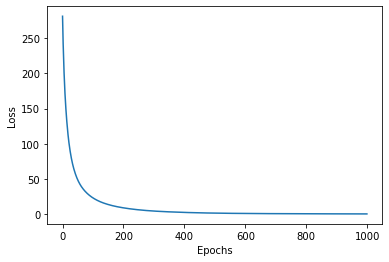

MSE on test set: 476.7392150576566
layers and their neurons: [16, 8, 4] learning_rate: 1e-06
Epoch 1/1000, loss 1.39620
Epoch 2/1000, loss 1.22817
Epoch 3/1000, loss 1.11539
Epoch 4/1000, loss 1.02922
Epoch 5/1000, loss 0.95855
Stopping early at epoch 5 with validation loss 4.39946


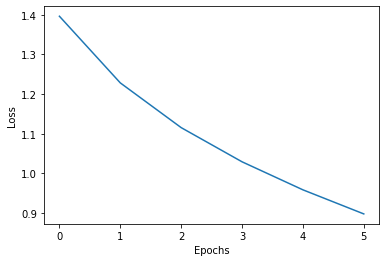

MSE on test set: 127.32822172198497
layers and their neurons: [4, 16, 4] learning_rate: 0.0001
Epoch 1/1000, loss 741.83643
Epoch 2/1000, loss 696.51287
Epoch 3/1000, loss 195.16432
Epoch 4/1000, loss 8.04930
Epoch 5/1000, loss 5.77545
Stopping early at epoch 5 with validation loss 26.95055


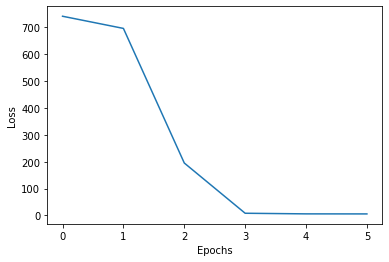

MSE on test set: 460.94678330943293
layers and their neurons: [4, 16, 4] learning_rate: 1e-05
Epoch 1/1000, loss 0.79665
Epoch 2/1000, loss 0.79504
Epoch 3/1000, loss 0.79343
Epoch 4/1000, loss 0.79183
Epoch 5/1000, loss 0.79023
Epoch 6/1000, loss 0.78864
Epoch 7/1000, loss 0.78705
Epoch 8/1000, loss 0.78547
Epoch 9/1000, loss 0.78389
Epoch 10/1000, loss 0.78231
Epoch 11/1000, loss 0.78075
Epoch 12/1000, loss 0.77918
Epoch 13/1000, loss 0.77762
Epoch 14/1000, loss 0.77607
Epoch 15/1000, loss 0.77452
Epoch 16/1000, loss 0.77297
Epoch 17/1000, loss 0.77143
Epoch 18/1000, loss 0.76989
Epoch 19/1000, loss 0.76836
Epoch 20/1000, loss 0.76683
Epoch 21/1000, loss 0.76531
Epoch 22/1000, loss 0.76379
Epoch 23/1000, loss 0.76228
Epoch 24/1000, loss 0.76077
Epoch 25/1000, loss 0.75926
Epoch 26/1000, loss 0.75776
Epoch 27/1000, loss 0.75627
Epoch 28/1000, loss 0.75478
Epoch 29/1000, loss 0.75329
Epoch 30/1000, loss 0.75181
Epoch 31/1000, loss 0.75033
Epoch 32/1000, loss 0.74885
Epoch 33/1000, loss

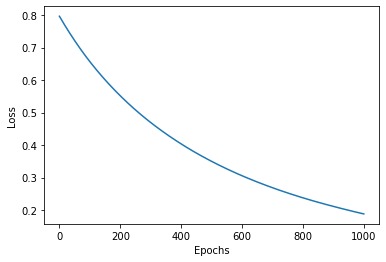

MSE on test set: 28.246765697849472
layers and their neurons: [4, 16, 4] learning_rate: 1e-06


In [6]:


# Load and preprocess the Iris Dataset
df2 = pd.read_csv('iris.csv')

# Standardize the data
X = df2.iloc[:, :-1].astype('float64')
X =  StandardScaler().fit_transform(X)
y= df2.iloc[:, -1]


unique_values = np.unique(y)

for i, value in enumerate(unique_values):
    y = np.where(y == value, i, y)
y = np.asarray(y)
y = y.reshape(-1, 1)
y = y.astype('float64')

# Split the dataset into training and testing sets
split_idx = int(0.8 * X.shape[0])
Xtrain, ytrain = X[:split_idx], y[:split_idx]
X_test, y_test  = X[split_idx:], y[split_idx:]

#split the dataset into training and validation sets
val_split = int(0.9 * Xtrain.shape[0])
X_train, y_train =Xtrain[:val_split], ytrain[:val_split]
X_val , y_val = Xtrain[val_split:], ytrain[val_split:]
print('X_train', X_train.shape, 'y_train', y_train.shape, 'X_val', X_val.shape, 'y_val', y_val.shape,'X_test', X_test.shape, 'y_test', y_test.shape)


# Two Hyperparameters( the learning rate and number of hidden layers).we can fine tune this Hyperparameters.
alphas = [1e-4, 1e-5, 1e-6]
neurons = [[32, 16], [16, 8, 4], [4, 16, 4]]

for n in neurons:
    losses = []
    for alpha in alphas:
        nn = NeuralNet(X.shape[1], 1, n)
        # Train the neural network
        
        epoch =[]
        loss, _ = nn.train_net(X_train, y_train,X_val , y_val, batch_size=64, alpha=alpha, epochs=1000, validation_data=1, early_stopping_patience=5)
        
        losses.append(loss)
        epoch.append(epoch)
        plt.plot(loss)
        plt.xlabel("Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()

        # Evaluate the performance of the neural network on the test set
        y_pred = nn.forward(X_test)
        mse = ((y_pred - y_test)**2).mean()

        print("MSE on test set:", mse)
        print('layers and their neurons:', n, 'learning_rate:', alpha)
